# Metasurface: microwave frequency selective surface (FSS) 

## Overview
We simulate microwave frequency selective surface (FSS) with 12GHz bandstop. periodic Metal cross array on dielectric substrate. Compare with Tidy3D example https://www.flexcompute.com/tidy3d/examples/notebooks/MicrowaveFrequencySelectiveSurface

## Geometry

running luminescent python frontend


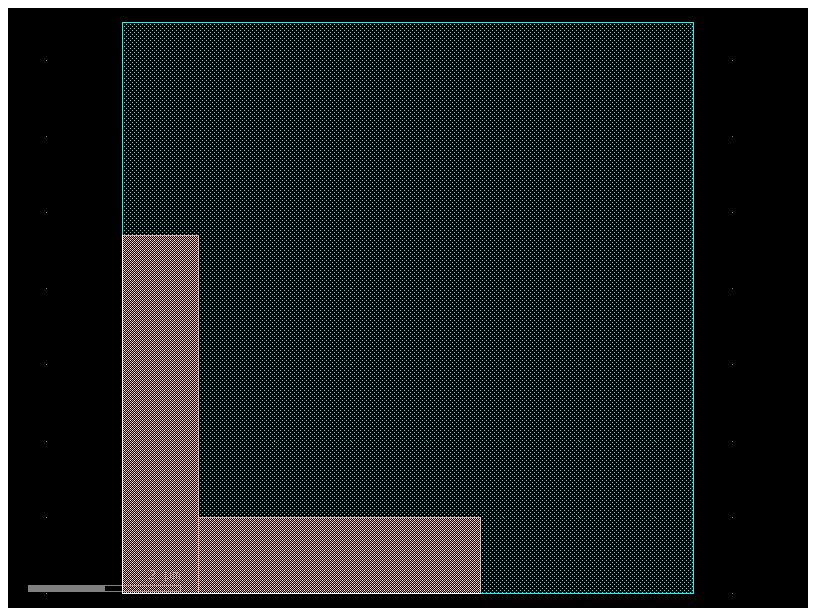

In [1]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

path = os.path.join("runs", "FSS")

# length and frequency units are arbitrary
f = 12  # center frequency GHz
bw = 4  # bandwidth
df = 0.05  # frequency step
wl1f = 300  # vacuum wavelength at 1 unit of frequency in your units
wl = wl1f / f  # characteristic wavelength
frequencies = np.linspace(f-bw/2, f+bw/2, round(bw/df+1))

# unit cell [mm]
P = 15  # periodicity
L = 9.4  # length of cross
W = 2.0  # width of cross stub
d = 2.2  # height of substrate
th = 0.1  # metal thickness
gap = 15.0  # air gap below and above - keeps resonant evanescent field from coupling to lossy PML
margin = 2.0

# adaptive meshing
nres = 8
dx0 = wl / nres
mesh_density = dx0 / 0.5

# materials_library
materials_library = lumi.MATERIALS_LIBRARY
materials_library["sub"] = lumi.Material(epsilon=2.5, mesh_density=mesh_density)
materials_library["PEC"] = lumi.PECMaterial(mesh_density=mesh_density)

# make geometry in gdsfactory. 1/4 section of unit cell due to symmetry
# alternatively can import .gds into gdsfactory

WG = (1, 0)
BBOX = (2, 0)

layer_stack = LayerStack(
    layers={
        "WG": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=th,
            zmin=d,
            material="PEC",
            mesh_order=1,
        ),
        "sub": LayerLevel(
            layer=LogicalLayer(layer=BBOX),
            thickness=d,
            zmin=0,
            material="sub",
            mesh_order=2,
        ),
    }
)

c = gf.Component()
c.add_polygon(
    [(0, 0), (0, L / 2), (W / 2, L / 2), (W / 2, 0)],
    layer=WG,
)
p = c.add_polygon(
    [(W / 2, W / 2), (W / 2, 0), (L / 2, 0), (L / 2, W / 2)],
    layer=WG,
)
c.add_polygon([(0, 0), (0, P / 2), (P / 2, P / 2), (P / 2, 0)], layer=BBOX)
c.plot()

## Solve

using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\FSS
0.25
0.25
0.25
loading problem from C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\FSS

failed fdtd binary execution

Video generated successfully at C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\FSS\simulation.gif!


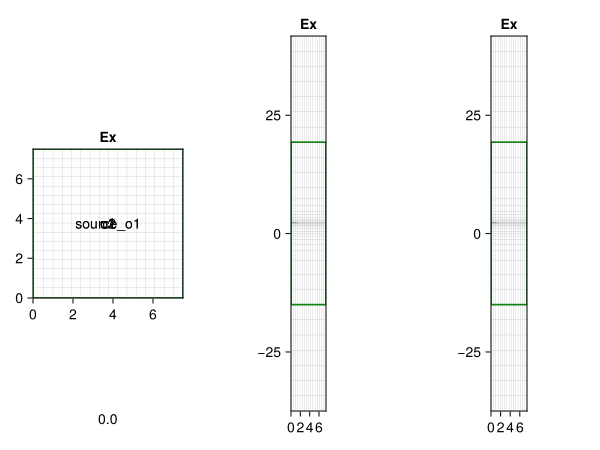

In [2]:
ports = [
    lumi.PlanePort(name="o1", z=d + th + gap, direction="+"),
    lumi.PlanePort(name="o2", z=-gap, direction="-"),
]
modes = [lumi.Mode(fields=[{"Ex": 1, "Hy": 1},{"Ey": 1, "Hx": -1}])]
sources = [lumi.Source("o1", source_port_margin=margin, frequency=f, bandwidth=bw)]

lumi.make(
    path,
    component=c,
    frequencies=frequencies,
    wl1f=wl1f,
    # antisymmetric/PEC/odd vs symmetric/PMC/even symmetry
    boundaries=["PEC", "PMC", "PML"],
    #
    sources=sources,
    ports=ports,
    modes=modes,
    zmin=-gap,
    zmax=d + th + gap + margin,
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    #
    gpu="CUDA",  # use GPU acceleration
    relative_courant=0.9,  # relative courant number between 0 and 1
    nres=nres,
    Tsim=50,  # max time [periods]
    field_decay_threshold=0.003,  # field decay threshold for stopping simulation
    saveat=0.5,
)
lumi.solve(path)
lumi.plot(path,views=[lumi.View('Ex',z=d + th/2)])

## Analysis

loading solution from C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\FSS


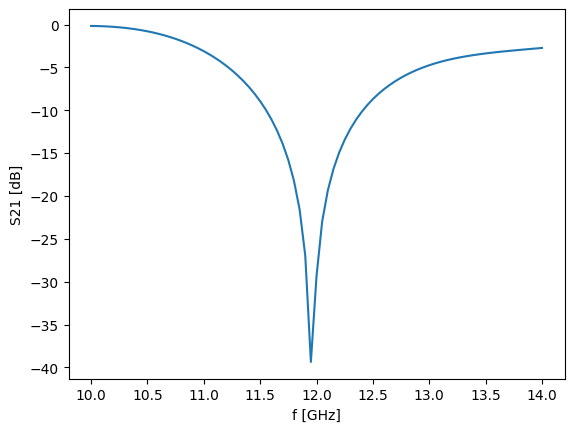

In [3]:
sol = lumi.load(path)
x = frequencies
y = [10 * math.log10(x) for x in lumi.query(sol,'T2,1')]
plt.plot(x, y)
plt.xlabel("f [GHz]")
plt.ylabel("S21 [dB]")
plt.show()